In [78]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.interpolate import make_interp_spline
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [79]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.full((self.world_height, self.world_width), '', dtype='<U1')
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """ 
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1
        
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1
                    
        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]] not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [80]:
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act() 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

You need to complete the learn() method of the following class to implement your RL algorithm.

In [81]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = defaultdict(lambda: {1: 0, 2: 0, 3: 0, 4: 0})  # Use defaultdict for sparse states
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.cliff_fall_records = []  # To record cliff fall events
        
    def act(self, state, is_training=True):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        state_tuple = tuple(state)
        
        if is_training and np.random.uniform(0, 1) < self.epsilon:
            # Exploration: random action
            return np.random.choice(self.action_space)
        else:
            # Exploitation: best action
            q_values = self.q_table[state_tuple]
            max_q = max(q_values.values())
            # Get all actions with max Q-value
            best_actions = [action for action, q_val in q_values.items() if q_val == max_q]
            return np.random.choice(best_actions)
    
    def learn(self):
        """Implements Q-learning algorithm."""
        rewards = []
        episodes_per_phase = self.num_episodes // 10  # For cliff fall analysis
        
        for episode in range(self.num_episodes):
            cumulative_reward = 0
            state = self.env.reset()
            done = False
            episode_cliff_falls = []  # Record cliff falls in this episode
            
            while not done:
                # Choose and take action
                action = self.act(state)
                next_state, reward, done, info = self.env.step(action)
                
                # Convert states to tuples for dictionary keys
                state_tuple = tuple(state)
                next_state_tuple = tuple(next_state)
                
                # Record if fall into cliff occurred
                if self.env._check_off_cliff(self.env.agent_pos) or self.env._check_off_cliff(self.env.box_pos):
                    cliff_pos = self.env.agent_pos if self.env._check_off_cliff(self.env.agent_pos) else self.env.box_pos
                    episode_cliff_falls.append(tuple(cliff_pos))
                
                # Q-learning update
                current_q = self.q_table[state_tuple][action]
                next_max_q = max(self.q_table[next_state_tuple].values()) if not done else 0
                
                # Q(s,a) = Q(s,a) + α[r + γ * max_a' Q(s',a') - Q(s,a)]
                new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
                self.q_table[state_tuple][action] = new_q
                
                cumulative_reward += reward
                state = next_state
            
            rewards.append(cumulative_reward)
            
            # Record cliff falls for this episode
            self.cliff_fall_records.append(episode_cliff_falls)
            
            # Decay epsilon for better convergence
            if episode % 1000 == 0 and episode > 0:
                self.epsilon *= 0.95
        
        return rewards

Here is the game interface where you can manually move the agent.

In [94]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['A' '_' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['_' 'A' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 2, state: (4, 1, 3, 1), actions: 1, reward: -15
Action: 1
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_

Example code to step random agent in the environment.

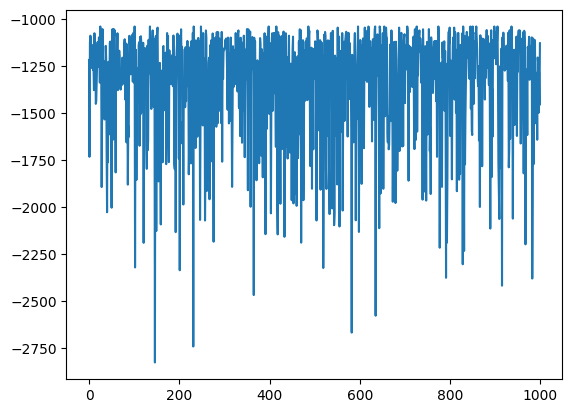

In [83]:
#Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

Train your own agent!

In [84]:
# Train the Q-learning agent
print("Training Q-learning agent...")
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=15000)
rewards = agent.learn()

# Calculate success rate
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Final success rate: {success_rate}")


Training Q-learning agent...
Final success rate: 0.8245


You need to complete the following method to visualize your training results.

In [85]:
def visualize(q_table, env):
    """Visualize the learned policy and value function."""
    v_table = {}
    policy = {}
    
    for state, action_values in q_table.items():
        # Value function: max Q-value for the state
        v_table[state] = max(action_values.values())
        # Policy: action with highest Q-value
        max_value = max(action_values.values())
        best_actions = [action for action, value in action_values.items() if value == max_value]
        policy[state] = best_actions[0]  # Take first best action if multiple
    
    print(f"State space size: {len(q_table)}")
    
    # Print top 20 state values
    print("\nTop 20 states by value:")
    sorted_states = sorted(v_table.items(), key=lambda x: x[1], reverse=True)[:20]
    for state, value in sorted_states:
        print(f"State {state}: Value = {value:.2f}, Policy = {policy[state]}")
    
    return v_table, policy

def analyze_cliff_fall_dynamics(cliff_fall_records, num_episodes, env):
    """Analyze cliff fall rates over training phases."""
    num_phases = 10
    episodes_per_phase = num_episodes // num_phases
    
    # Initialize cliff cell positions from environment
    cliff_cells = []
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            cliff_cells.append((row, A[1]))
    
    # Create heatmap data for each phase
    heatmap_data = np.zeros((env.world_height, env.world_width, num_phases))
    
    for phase in range(num_phases):
        start_episode = phase * episodes_per_phase
        end_episode = (phase + 1) * episodes_per_phase
        
        # Count falls per cliff cell in this phase
        phase_falls = defaultdict(int)
        phase_total_episodes = 0
        
        for episode in range(start_episode, min(end_episode, len(cliff_fall_records))):
            episode_falls = cliff_fall_records[episode]
            phase_total_episodes += 1
            
            for cliff_pos in episode_falls:
                phase_falls[cliff_pos] += 1
        
        # Calculate fall rates
        for cliff_pos in cliff_cells:
            fall_rate = phase_falls[cliff_pos] / phase_total_episodes if phase_total_episodes > 0 else 0
            heatmap_data[cliff_pos[0], cliff_pos[1], phase] = fall_rate
    
    # Plot heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for phase in range(num_phases):
        ax = axes[phase]
        sns.heatmap(heatmap_data[:, :, phase], ax=ax, cmap='Reds', 
                   cbar=True, vmin=0, vmax=0.5)
        ax.set_title(f'Phase {phase + 1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    plt.tight_layout()
    plt.suptitle('Cliff Fall Rates During Training Phases', y=1.02)
    plt.show()
    
    return heatmap_data

def visualize_enhanced_policy_and_values(agent, env, num_top_states=25):
    """Create comprehensive policy and value function visualizations."""
    # Calculate value table and policy
    v_table = {}
    policy_table = {}
    
    for state, action_values in agent.q_table.items():
        v_table[state] = max(action_values.values())
        policy_table[state] = max(action_values.items(), key=lambda x: x[1])[0]
    
    # Create visualization for key states
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Top states by value
    top_states = sorted(v_table.items(), key=lambda x: x[1], reverse=True)[:num_top_states]
    
    state_indices = range(len(top_states))
    values = [val for _, val in top_states]
    state_labels = [f'({s[0]},{s[1]})\n({s[2]},{s[3]})' for s, _ in top_states]
    
    bars = ax1.bar(state_indices, values, color='skyblue', alpha=0.7)
    ax1.set_xlabel('State (Agent Pos, Box Pos)', fontsize=12)
    ax1.set_ylabel('State Value', fontsize=12)
    ax1.set_title(f'Top {num_top_states} States by Value', fontsize=14, fontweight='bold')
    ax1.set_xticks(state_indices)
    ax1.set_xticklabels(state_labels, rotation=45, ha='right')
    
    # Add value annotations on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                f'{value:.1f}', ha='center', va='bottom', rotation=0, fontsize=8)
    
    # Plot 2: Policy distribution
    action_names = ['Up', 'Down', 'Left', 'Right']
    action_counts = {action: 0 for action in agent.action_space}
    
    for state, action in policy_table.items():
        action_counts[action] += 1
    
    total_states = len(policy_table)
    action_percentages = [action_counts[action]/total_states * 100 
                         for action in agent.action_space]
    
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    wedges, texts, autotexts = ax2.pie(action_percentages, labels=action_names, 
                                      colors=colors, autopct='%1.1f%%', startangle=90)
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax2.set_title('Policy Action Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("="*80)
    print("POLICY AND VALUE ANALYSIS")
    print("="*80)
    print(f"Total states: {len(v_table):,}")
    print(f"Average state value: {np.mean(list(v_table.values())):.2f}")
    print(f"Maximum state value: {max(v_table.values()):.2f}")
    print(f"Minimum state value: {min(v_table.values()):.2f}")
    print("\nTop 10 Most Valuable States:")
    print("Rank | State (Agent, Box) | Value | Best Action")
    print("-" * 55)
    
    for i, (state, value) in enumerate(top_states[:10]):
        action_name = ['Up', 'Down', 'Left', 'Right'][policy_table[state]-1]
        print(f"{i+1:4} | ({state[0]:2},{state[1]:2}) ({state[2]:2},{state[3]:2}) | {value:6.1f} | {action_name}")
    
    return v_table, policy_table



def analyze_cliff_fall_dynamics_1(agent, env):
    """Analyze per-cell cliff fall rates over training phases."""
    num_phases = 10
    episodes_per_phase = agent.num_episodes // num_phases
    
    # Get cliff cells
    cliff_cells = []
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            cliff_cells.append((row, A[1]))
    
    # Calculate fall rates per cell per phase
    fall_rates = np.zeros((len(cliff_cells), num_phases))
    
    for phase in range(num_phases):
        start_ep = phase * episodes_per_phase
        end_ep = min((phase + 1) * episodes_per_phase, len(agent.cliff_fall_records))
        
        # Count falls per cell
        cell_counts = {}
        for episode in range(start_ep, end_ep):
            for cliff_pos in agent.cliff_fall_records[episode]:
                cell_counts[cliff_pos] = cell_counts.get(cliff_pos, 0) + 1
        
        # Store rates
        for i, cell in enumerate(cliff_cells):
            fall_rates[i, phase] = cell_counts.get(cell, 0) / episodes_per_phase
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    plt.imshow(fall_rates, aspect='auto', cmap='Reds')
    plt.colorbar(label='Fall Rate')
    plt.xlabel('Training Phase')
    plt.ylabel('Cliff Cell')
    plt.title('Per-Cell Cliff Fall Rates Over Training')
    plt.xticks(range(num_phases), [f'P{i+1}' for i in range(num_phases)])
    plt.yticks(range(len(cliff_cells)), [f'{cell}' for cell in cliff_cells])
    plt.show()
    
    return fall_rates, cliff_cells



def plot_cliff_fall_trend(agent, env):
    """Plot cliff fall percentage trend across training phases."""
    num_phases = 10
    episodes_per_phase = agent.num_episodes // num_phases
    
    # Calculate fall percentage per phase
    fall_percentages = []
    
    for phase in range(num_phases):
        start_ep = phase * episodes_per_phase
        end_ep = min((phase + 1) * episodes_per_phase, len(agent.cliff_fall_records))
        
        # Count episodes with falls in this phase
        episodes_with_falls = 0
        for episode in range(start_ep, end_ep):
            if len(agent.cliff_fall_records[episode]) > 0:
                episodes_with_falls += 1
        
        fall_percentage = (episodes_with_falls / episodes_per_phase) * 100
        fall_percentages.append(fall_percentage)
    
    # Plot clean line chart
    plt.figure(figsize=(12, 6))
    phases = range(1, num_phases + 1)
    
    # Just the actual data points connected by straight lines
    plt.plot(phases, fall_percentages, 'o-', linewidth=3, markersize=8, 
             color='red', alpha=0.8, label='Fall-off Rate')
    
    # Add values on top of dots
    for i, v in enumerate(fall_percentages):
        plt.text(phases[i], v + 1, f'{v:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    # Calculate improvement
    improvement = ((fall_percentages[0] - fall_percentages[-1]) / fall_percentages[0]) * 100
    
    # Add improvement annotation
    plt.annotate(f'Overall Improvement: {improvement:.1f}%', 
                xy=(0.7, 0.8), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="green", alpha=0.8),
                fontsize=12, fontweight='bold')
    
    plt.xlabel('Training Phase', fontsize=12, fontweight='bold')
    plt.ylabel('Fall-off Rate (%)', fontsize=12, fontweight='bold')
    plt.title('Cliff Fall-off Rate Reduction During Training', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(phases)
    plt.tight_layout()
    plt.show()
    
    return fall_percentages, improvement


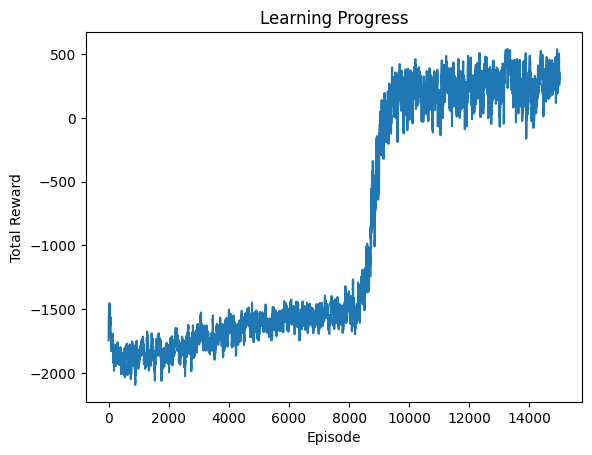

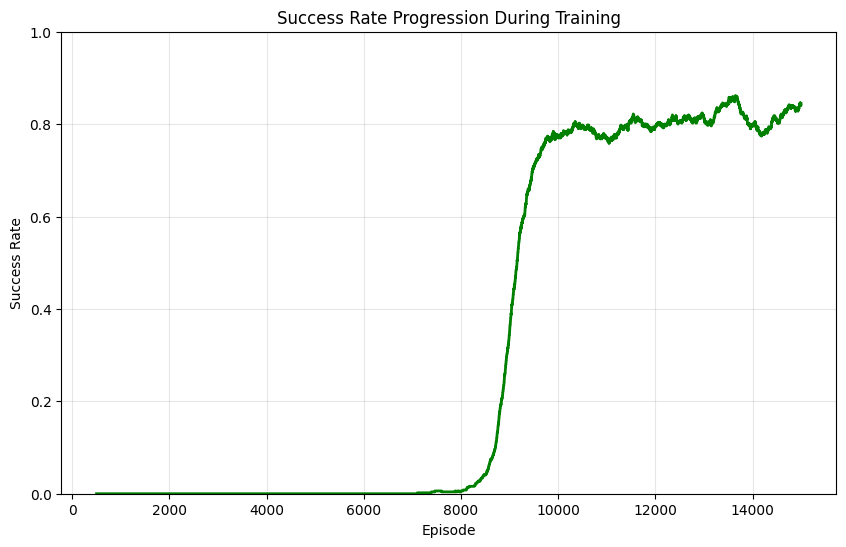


Visualizing learned policy...
State space size: 2213

Top 20 states by value:
State (2, 13, 3, 13): Value = 998.00, Policy = 2
State (1, 13, 2, 13): Value = 985.02, Policy = 2
State (1, 13, 3, 13): Value = 983.73, Policy = 2
State (0, 13, 1, 13): Value = 971.17, Policy = 2
State (0, 13, 2, 13): Value = 970.73, Policy = 2
State (1, 12, 2, 13): Value = 970.62, Policy = 4
State (0, 12, 1, 13): Value = 956.46, Policy = 4
State (1, 12, 1, 13): Value = 940.89, Policy = 1
State (0, 11, 1, 13): Value = 940.89, Policy = 4
State (1, 11, 1, 12): Value = 926.48, Policy = 4
State (1, 11, 1, 13): Value = 923.90, Policy = 1
State (1, 10, 1, 11): Value = 911.22, Policy = 4
State (1, 10, 1, 12): Value = 910.97, Policy = 4
State (0, 11, 1, 12): Value = 910.81, Policy = 2
State (2, 11, 1, 12): Value = 910.10, Policy = 1
State (1, 9, 1, 10): Value = 895.11, Policy = 4
State (1, 9, 1, 11): Value = 894.78, Policy = 4
State (2, 10, 1, 11): Value = 894.49, Policy = 1
State (0, 10, 1, 11): Value = 894.47, Pol

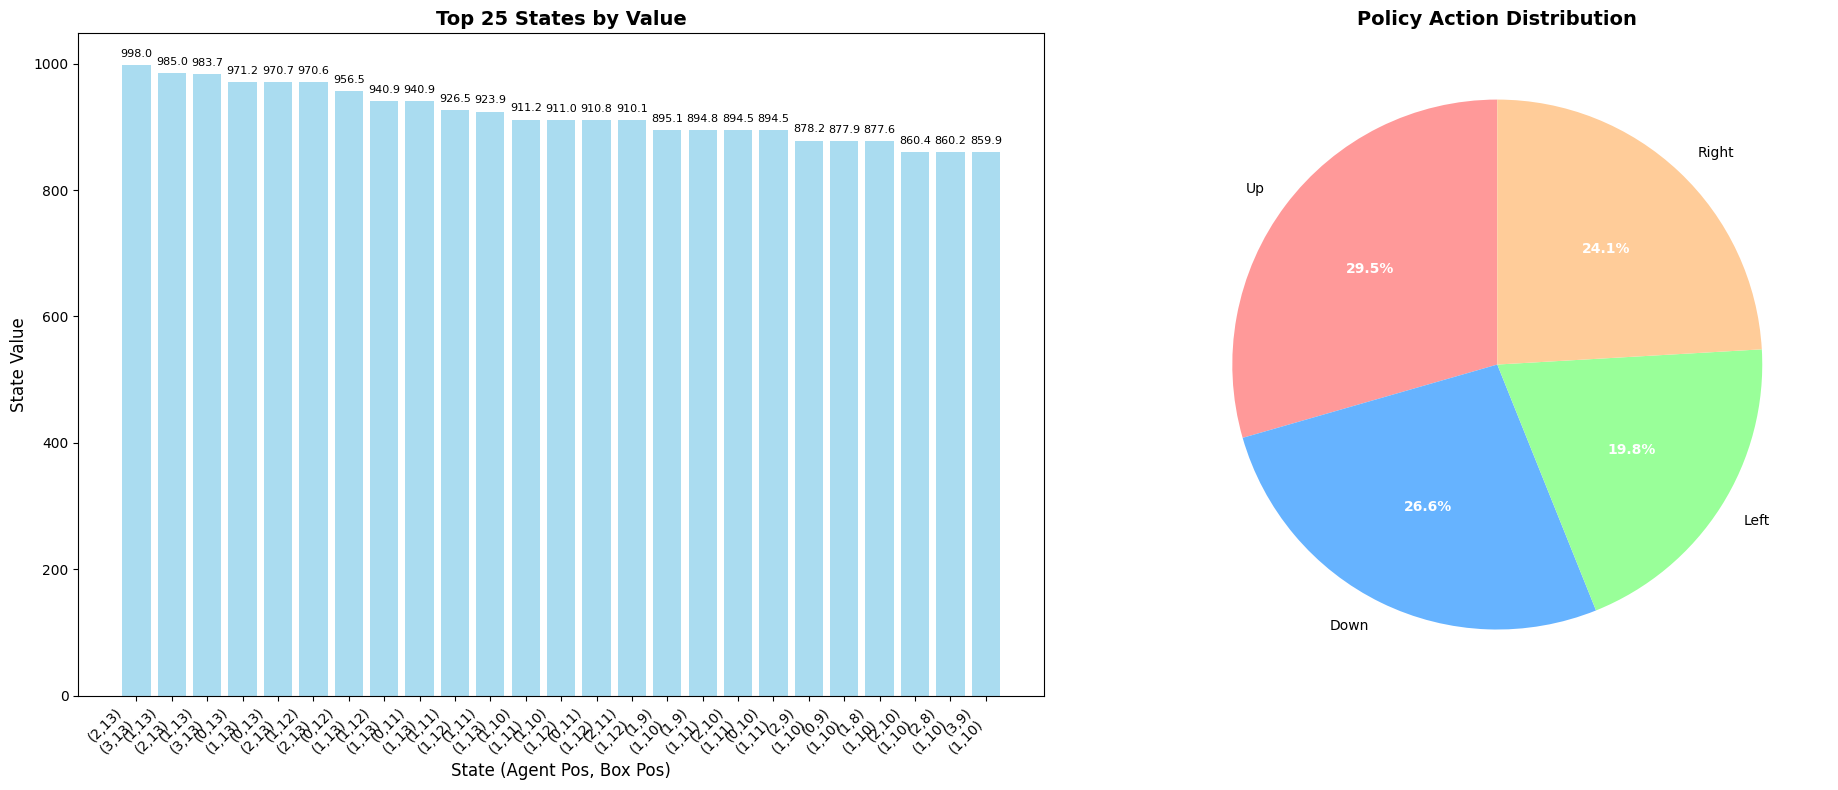

POLICY AND VALUE ANALYSIS
Total states: 2,213
Average state value: -47.84
Maximum state value: 998.00
Minimum state value: -284.92

Top 10 Most Valuable States:
Rank | State (Agent, Box) | Value | Best Action
-------------------------------------------------------
   1 | ( 2,13) ( 3,13) |  998.0 | Down
   2 | ( 1,13) ( 2,13) |  985.0 | Down
   3 | ( 1,13) ( 3,13) |  983.7 | Down
   4 | ( 0,13) ( 1,13) |  971.2 | Down
   5 | ( 0,13) ( 2,13) |  970.7 | Down
   6 | ( 1,12) ( 2,13) |  970.6 | Right
   7 | ( 0,12) ( 1,13) |  956.5 | Right
   8 | ( 1,12) ( 1,13) |  940.9 | Up
   9 | ( 0,11) ( 1,13) |  940.9 | Right
  10 | ( 1,11) ( 1,12) |  926.5 | Right

 Analyzing per-cell cliff fall dynamics...


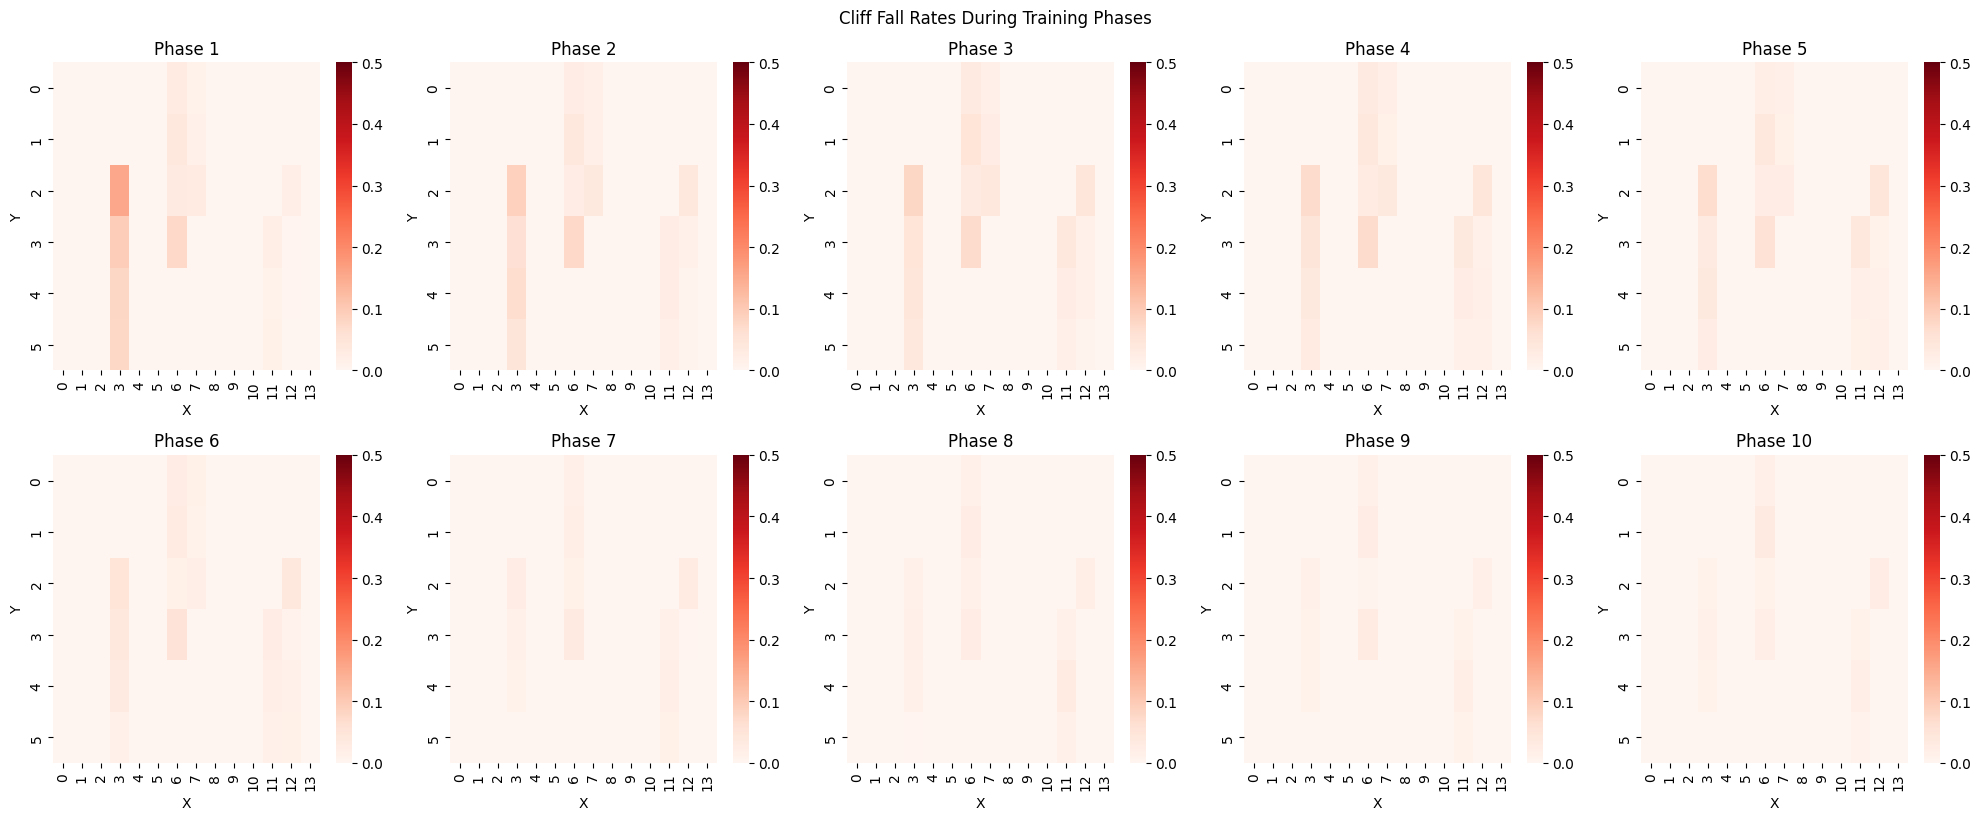


 Plotting cliff fall dynamics heatmap...


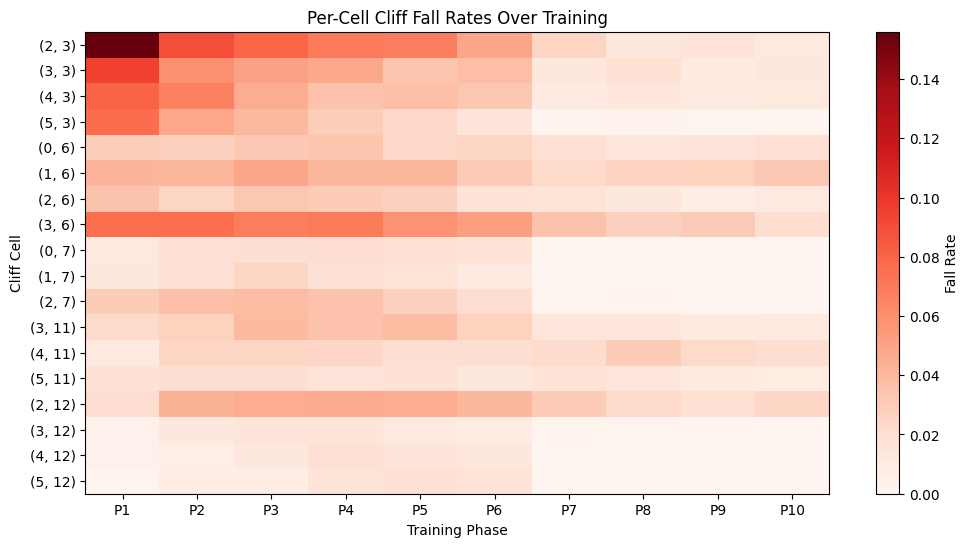


 Plotting cliff fall trend...


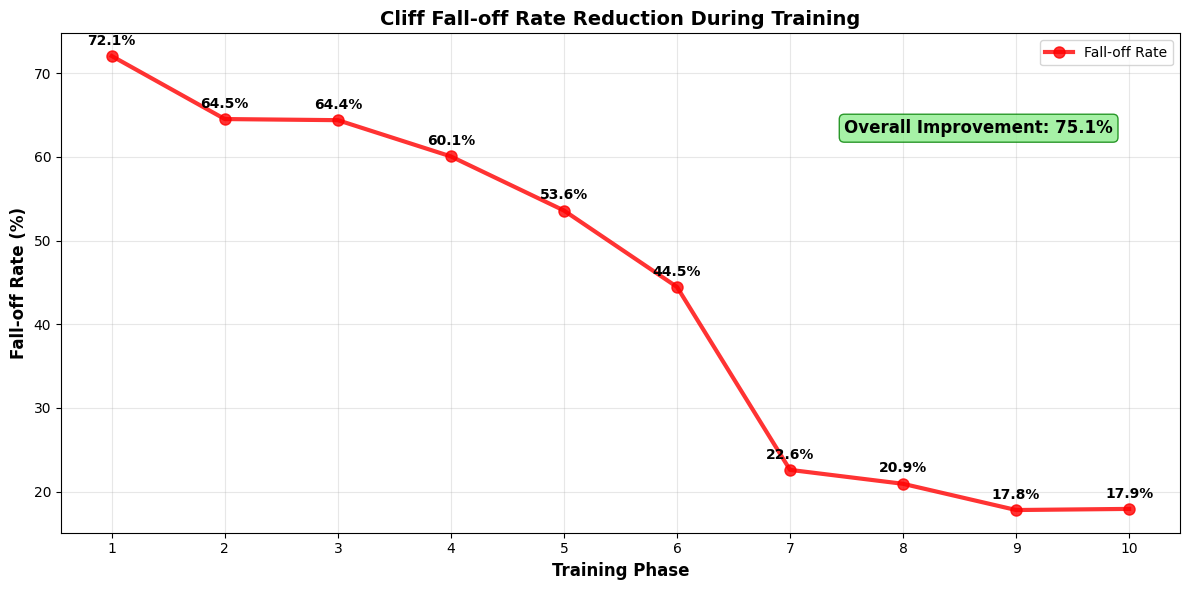

Overall improvement: 75.1%


In [86]:
# Smooth plot
weight=0.95
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Progress')

# Success rate progression 
plt.figure(figsize=(10, 6))
window = 500
success_rates = []
for i in range(window, len(rewards)):
    success_rate = np.sum(np.array(rewards[i-window:i]) > 0) / window
    success_rates.append(success_rate)

plt.plot(range(window, len(rewards)), success_rates, 'g-', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title('Success Rate Progression During Training')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()


# Visualize learned policy
print("\nVisualizing learned policy...")
v_table, policy = visualize(agent.q_table, env)

# Policy and value visualization
print("\n Analyzing learned policy and values...")
v_table, policy_table = visualize_enhanced_policy_and_values(agent, env)

print("\n Analyzing per-cell cliff fall dynamics...")
fall_dynamics_results = analyze_cliff_fall_dynamics(agent.cliff_fall_records, agent.num_episodes, env)

print("\n Plotting cliff fall dynamics heatmap...")
rfall_rates, cliff_cells = analyze_cliff_fall_dynamics_1(agent, env)

#Plot the graph
print("\n Plotting cliff fall trend...")
fall_rates, improvement = plot_cliff_fall_trend(agent, env)
print(f"Overall improvement: {improvement:.1f}%")

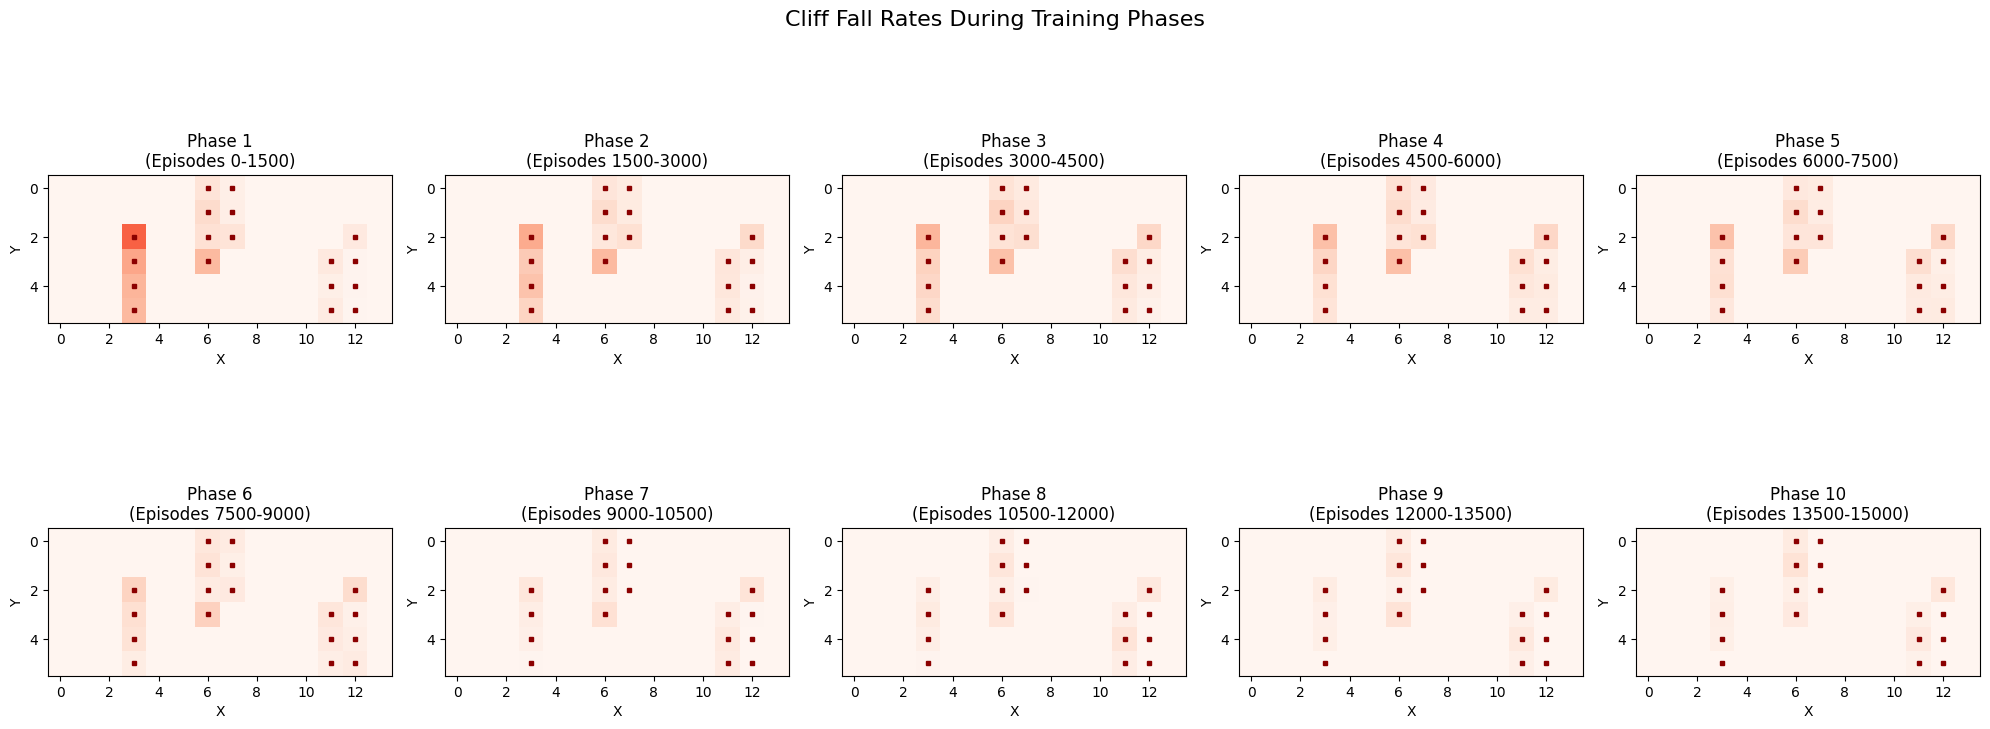

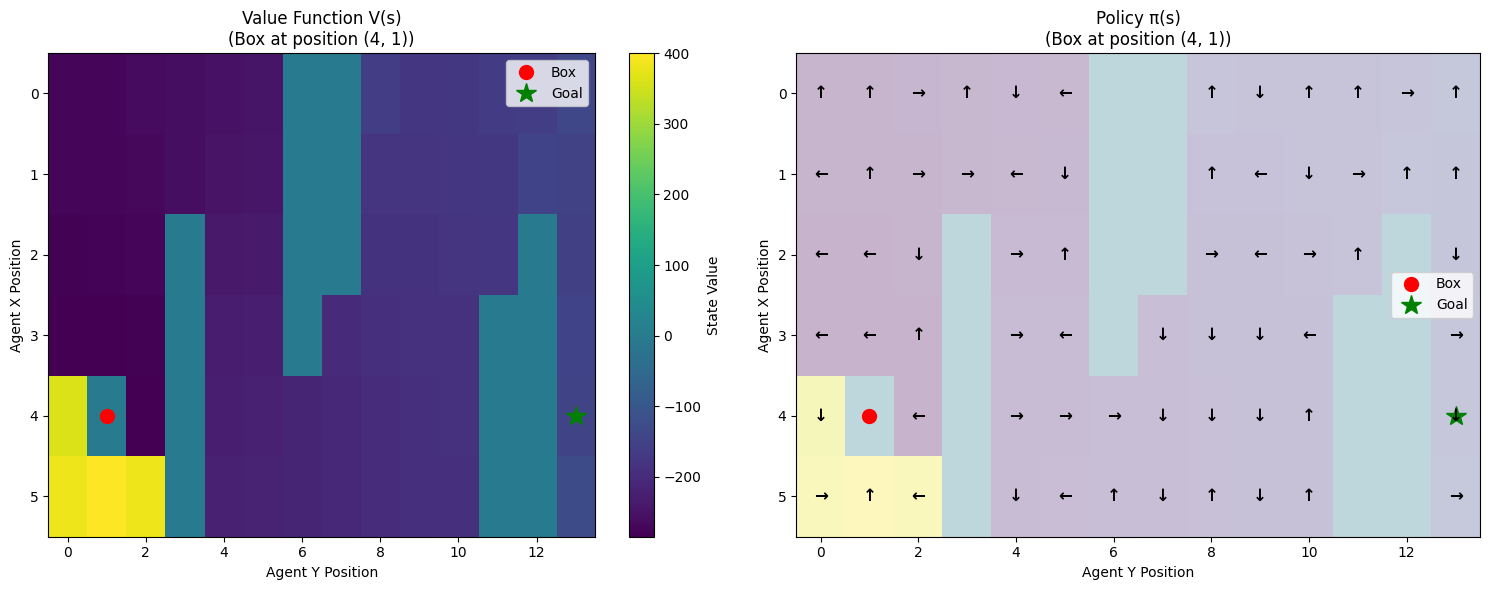

Success in 36 steps!


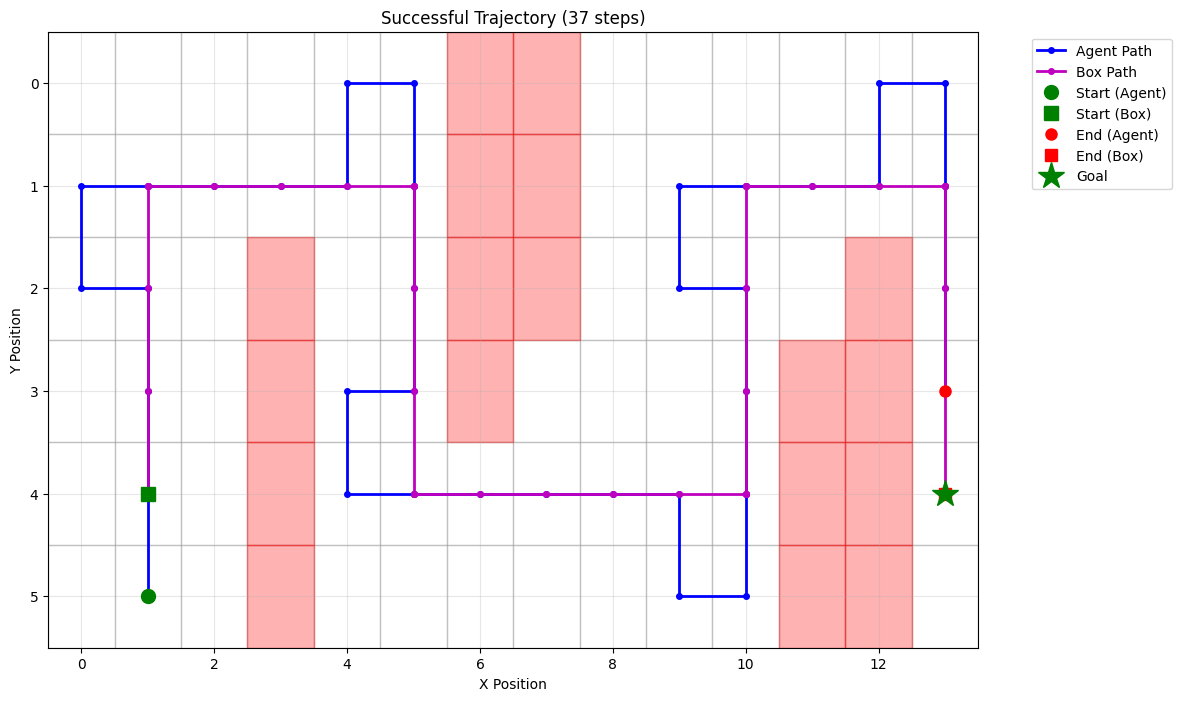

In [87]:
def create_cliff_fall_heatmaps(cliff_fall_records, num_episodes, env):
    """Create the required cliff fall rate heatmaps across training phases"""
    num_phases = 10
    episodes_per_phase = num_episodes // num_phases
    
    # Get all cliff cell positions
    cliff_cells = []
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            cliff_cells.append((row, A[1]))
    
    # Create heatmap data
    heatmap_data = np.zeros((env.world_height, env.world_width, num_phases))
    
    for phase in range(num_phases):
        start_ep = phase * episodes_per_phase
        end_ep = (phase + 1) * episodes_per_phase
        phase_falls = defaultdict(int)
        phase_total = 0
        
        for episode in range(start_ep, min(end_ep, len(cliff_fall_records))):
            episode_falls = cliff_fall_records[episode]
            phase_total += 1
            for cliff_pos in episode_falls:
                phase_falls[cliff_pos] += 1
        
        # Calculate fall rates
        for cliff_pos in cliff_cells:
            fall_rate = phase_falls[cliff_pos] / phase_total if phase_total > 0 else 0
            heatmap_data[cliff_pos[0], cliff_pos[1], phase] = fall_rate
    
    # Plot heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for phase in range(num_phases):
        ax = axes[phase]
        im = ax.imshow(heatmap_data[:, :, phase], cmap='Reds', vmin=0, vmax=0.3)
        ax.set_title(f'Phase {phase+1}\n(Episodes {phase*episodes_per_phase}-{(phase+1)*episodes_per_phase})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        # Mark cliff positions
        for cliff_pos in cliff_cells:
            ax.plot(cliff_pos[1], cliff_pos[0], 's', color='darkred', markersize=3)
    
    plt.tight_layout()
    plt.suptitle('Cliff Fall Rates During Training Phases', y=1.02, fontsize=16)
    plt.show()
    
    return heatmap_data

# Generate the required cliff fall analysis
cliff_heatmaps = create_cliff_fall_heatmaps(agent.cliff_fall_records, agent.num_episodes, env)

def visualize_value_function(agent, env):
    """Visualize the value function for key states"""
    # Create value function for initial state (box at (4,1))
    box_pos = (4, 1)  # Initial box position
    value_map = np.zeros((env.world_height, env.world_width))
    policy_map = np.full((env.world_height, env.world_width), '', dtype=object)
    
    action_symbols = {1: '↑', 2: '↓', 3: '←', 4: '→'}
    
    for agent_x in range(env.world_height):
        for agent_y in range(env.world_width):
            state = (agent_x, agent_y, box_pos[0], box_pos[1])
            if state in agent.q_table:
                value_map[agent_x, agent_y] = max(agent.q_table[state].values())
                best_action = max(agent.q_table[state].items(), key=lambda x: x[1])[0]
                policy_map[agent_x, agent_y] = action_symbols[best_action]
    
    # Plot value function
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Value function heatmap
    im = ax1.imshow(value_map, cmap='viridis', aspect='auto')
    ax1.set_title(f'Value Function V(s)\n(Box at position {box_pos})')
    ax1.set_xlabel('Agent Y Position')
    ax1.set_ylabel('Agent X Position')
    plt.colorbar(im, ax=ax1, label='State Value')
    
    # Mark special positions
    ax1.plot(box_pos[1], box_pos[0], 'ro', markersize=10, label='Box')
    ax1.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=15, label='Goal')
    ax1.legend()
    
    # Policy visualization
    ax2.imshow(value_map, cmap='viridis', aspect='auto', alpha=0.3)
    for i in range(env.world_height):
        for j in range(env.world_width):
            if policy_map[i, j] != '':
                ax2.text(j, i, policy_map[i, j], ha='center', va='center', 
                        fontsize=12, fontweight='bold', color='black')
    
    ax2.set_title(f'Policy π(s)\n(Box at position {box_pos})')
    ax2.set_xlabel('Agent Y Position')
    ax2.set_ylabel('Agent X Position')
    ax2.plot(box_pos[1], box_pos[0], 'ro', markersize=10, label='Box')
    ax2.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=15, label='Goal')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

visualize_value_function(agent, env)

def plot_successful_trajectory(agent, env):
    """Plot a successful trajectory"""
    # Run until success
    test_env = CliffBoxGridWorld(render=False)
    state = test_env.reset()
    trajectory = []
    
    for step in range(100):  # Increased step limit
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = test_env.step(action)
        
        trajectory.append({
            'step': step,
            'agent_pos': test_env.agent_pos.copy(),
            'box_pos': test_env.box_pos.copy(),
            'action': action,
            'reward': reward
        })
        
        state = next_state
        if all(test_env.box_pos == test_env.goal_pos):
            print(f"Success in {step} steps!")
            break
        if done:
            break
    
    # Plot trajectory
    plt.figure(figsize=(12, 8))
    
    # Create grid
    for i in range(env.world_height):
        for j in range(env.world_width):
            plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                            facecolor='white', edgecolor='gray', alpha=0.3))
    
    # Mark dangerous regions
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            plt.gca().add_patch(plt.Rectangle((A[1]-0.5, row-0.5), 1, 1, 
                                            color='red', alpha=0.3))
    
    # Plot trajectory
    agent_x = [pos['agent_pos'][1] for pos in trajectory]
    agent_y = [pos['agent_pos'][0] for pos in trajectory]
    box_x = [pos['box_pos'][1] for pos in trajectory]
    box_y = [pos['box_pos'][0] for pos in trajectory]
    
    plt.plot(agent_x, agent_y, 'bo-', linewidth=2, markersize=4, label='Agent Path')
    plt.plot(box_x, box_y, 'mo-', linewidth=2, markersize=4, label='Box Path')
    
    # Mark key positions
    plt.plot(agent_x[0], agent_y[0], 'go', markersize=10, label='Start (Agent)')
    plt.plot(box_x[0], box_y[0], 'gs', markersize=10, label='Start (Box)')
    plt.plot(agent_x[-1], agent_y[-1], 'ro', markersize=8, label='End (Agent)')
    plt.plot(box_x[-1], box_y[-1], 'rs', markersize=8, label='End (Box)')
    plt.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=20, label='Goal')
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Successful Trajectory ({len(trajectory)} steps)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.5, env.world_width - 0.5)
    plt.ylim(-0.5, env.world_height - 0.5)
    plt.gca().invert_yaxis()
    plt.show()
    
    return trajectory

# Plot a successful trajectory
success_trajectory = plot_successful_trajectory(agent, env)




Evaluate the agent without exploration

In [88]:
env = CliffBoxGridWorld(render=True)
total_run = 1000
success = 0

for i in range(total_run):
    state = env.reset()
    done = False
    rewards = []
    
    while not done: 
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward)
    if sum(rewards) > 0:
        success += 1
print(success/total_run)

1.0


Evaluate the agent with exploration and visualization

In [92]:
env = CliffBoxGridWorld(render=True)
state = env.reset()
env.print_world()
done = False
rewards = []

while not done: # Run until game terminated
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['A' '_' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['_' 'A' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 2, state: (4, 1, 3, 1), actions: 1, reward: -15
Action: 1
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_

Training sparse reward agent...


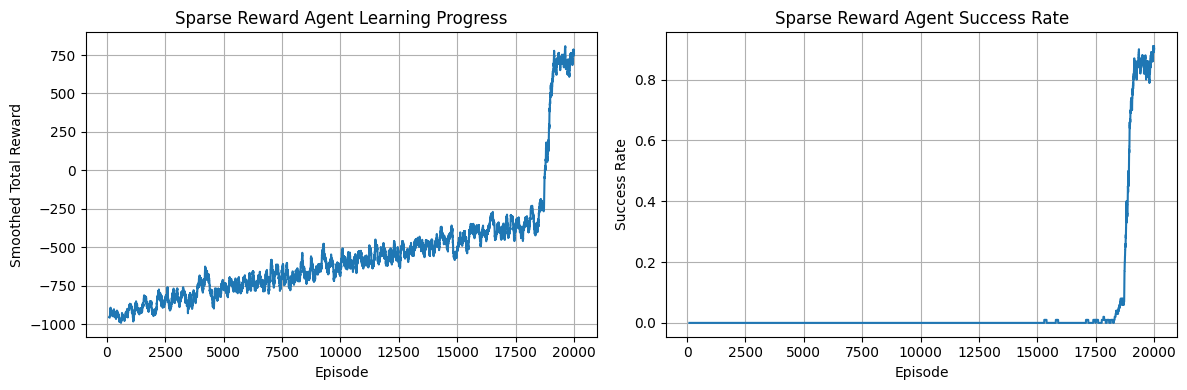

Sparse reward agent success rate: 1.000


In [90]:
# Sparse reward version
class SparseRewardAgent(RLAgent):
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        super().__init__(env, num_episodes, epsilon, alpha, gamma)
        # Initialize Q-table with optimistic values to encourage exploration
        for state in self.q_table:
            for action in self.q_table[state]:
                self.q_table[state][action] = 10.0  # Optimistic initialization
    
    def learn(self):
        """Q-learning with sparse rewards only."""
        rewards = []
        
        for episode in range(self.num_episodes):
            state = self.env.reset()
            done = False
            cumulative_reward = 0
            episode_cliff_falls = []
            
            while not done:
                action = self.act(state)
                next_state, reward, done, info = self.env.step(action)
                
                # Modify reward to be sparse
                sparse_reward = 0
                if self.env._check_off_cliff(self.env.agent_pos) or self.env._check_off_cliff(self.env.box_pos):
                    sparse_reward = -1000
                    cliff_pos = self.env.agent_pos if self.env._check_off_cliff(self.env.agent_pos) else self.env.box_pos
                    episode_cliff_falls.append(tuple(cliff_pos))
                elif all(self.env.box_pos == self.env.goal_pos):
                    sparse_reward = 1000
                else:
                    sparse_reward = -1  # Small penalty for each step to encourage efficiency
                
                # Q-learning update with sparse reward
                state_tuple = tuple(state)
                next_state_tuple = tuple(next_state)
                
                current_q = self.q_table[state_tuple][action]
                next_max_q = max(self.q_table[next_state_tuple].values()) if not done else 0
                
                new_q = current_q + self.alpha * (sparse_reward + self.gamma * next_max_q - current_q)
                self.q_table[state_tuple][action] = new_q
                
                cumulative_reward += sparse_reward
                state = next_state
            
            rewards.append(cumulative_reward)
            self.cliff_fall_records.append(episode_cliff_falls)
            
            # Adaptive epsilon decay
            if episode % 1000 == 0 and episode > 0:
                self.epsilon = max(0.01, self.epsilon * 0.9)
        
        return rewards

# Sparse reward agent
print("Training sparse reward agent...")
env_sparse = CliffBoxGridWorld()
agent_sparse = SparseRewardAgent(env_sparse, num_episodes=20000, epsilon=0.2, alpha=0.1, gamma=0.99)
rewards_sparse = agent_sparse.learn()

# Plot sparse reward learning
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
window_size = 100
smoothed_sparse = np.convolve(rewards_sparse, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size-1, len(rewards_sparse)), smoothed_sparse)
plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.title('Sparse Reward Agent Learning Progress')
plt.grid(True)

plt.subplot(1, 2, 2)
success_rates_sparse = []
for i in range(window_size, len(rewards_sparse)):
    success_rate = np.sum(np.array(rewards_sparse[i-window_size:i]) > 0) / window_size
    success_rates_sparse.append(success_rate)

plt.plot(range(window_size, len(rewards_sparse)), success_rates_sparse)
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title('Sparse Reward Agent Success Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate sparse reward agent
success_count_sparse = 0
for i in range(500):
    state = env_sparse.reset()
    done = False
    
    while not done:
        action = agent_sparse.act(state, is_training=False)
        next_state, reward, done, info = env_sparse.step(action)
        state = next_state
    
    if reward > 0:
        success_count_sparse += 1

print(f"Sparse reward agent success rate: {success_count_sparse/500:.3f}")